In [87]:
from pathlib import Path
import sys

BASE_PATH = Path('../')
PATH_TO_DATA = BASE_PATH/'data'
PATH_TO_MODELS = BASE_PATH/'checkpoints'
PATH_TO_CACHE = BASE_PATH/'cache'

PATH_TO_CACHE.mkdir(exist_ok=True, parents=True)
PATH_TO_DATA.mkdir(exist_ok=True, parents=True)
PATH_TO_MODELS.mkdir(exist_ok=True, parents=True)

sys.path.append(str(BASE_PATH/'..'))

#### <b>Load Libraries</b>

In [102]:
from copy import deepcopy
from tqdm import tqdm
import time
import random
from pathlib import Path
import pickle

from PIL import Image

import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torchvision import models
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader, ConcatDataset

from utils import progress_bar, load_model

#### <b>Notebook Constants</b>

In [107]:
RANDOM_STATE = 42
BATCH_SIZE = 64
NUM_WORKERS = 8
DEVICE = 'cuda'
NUM_CLASSES = 8

In [90]:
def set_random_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

#### <b>Define Custom Dataset</b>

In [150]:
class KoreanDataset(Dataset):
    def __init__(self, manifest, image_directory, train_mode):

        if train_mode:
            self.transform = transforms.Compose([
                transforms.Resize(128),
                transforms.RandomHorizontalFlip(),
                transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                transforms.ToTensor()
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(128),
                transforms.ToTensor()
            ])

        image_directory = Path(image_directory)
        age_class_to_label = {
            "a": 0, "b": 1, "c": 2, "d": 3, "e": 4, "f": 5, "g": 6, "h": 7
        }
        
        self.filenames = [image_directory/x for x in manifest['image_path']]
        self.labels = [age_class_to_label[x] for x in manifest['age_class']]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img = self.transform(Image.open(self.filenames[idx]))
        label = self.labels[idx]

        return img, label

#### <b>Evalution utils</b>

In [151]:
def downstream_task_performance(model, dataloader):
    model.eval()
    top2_correct = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)

            _, preds = outputs.max(1)
            total += targets.size(0)
            correct += preds.eq(targets).sum().item()

            # Top-2 accuracy.
            _, top2_preds = outputs.topk(2, dim=1)
            top2_correct += top2_preds.eq(targets.view(-1, 1).expand_as(top2_preds)).any(dim=1).sum().item()

            progress_bar(batch_idx, len(dataloader), f'Acc: {100*correct/total:.2f}%%% Top2 Acc: {100*top2_correct/total:.2f}%%%')
    
    return 100*correct/total, 100*top2_correct/total

In [152]:
from MIA.score import get_logits, lira_offline, lira_online

def lira(target_net, forget_manifest_filename, retain_manifest_filename, data_split_filename=None, cached=True):

    num_aug = 1
    fix_variance = False

    train_mode = True if num_aug > 1 else False
    forget_manifest = pd.read_csv(PATH_TO_DATA/forget_manifest_filename)
    retain_manifest = pd.read_csv(PATH_TO_DATA/retain_manifest_filename)
    forget_dataset = KoreanDataset(forget_manifest, PATH_TO_DATA/'images', train_mode=train_mode)
    retain_dataset = KoreanDataset(retain_manifest, PATH_TO_DATA/'images', train_mode=train_mode)
    dataset = ConcatDataset([forget_dataset, retain_dataset])
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    if data_split_filename is not None:
        with open(PATH_TO_DATA/data_split_filename, 'rb') as file:
            data_split = pickle.load(file)
    else:
        data_split = None
    

    if cached and (PATH_TO_CACHE/'shadow_logits.npy').is_file():
        shadow_logits = np.load(PATH_TO_CACHE/'shadow_logits.npy')
        print('Shadow logits were brought from cache')
    else:
        shadow_nets = [load_model(state_dict, 8).to(DEVICE) for state_dict in (PATH_TO_MODELS/'shadow').glob('*/*')]
        shadow_logits = []
        for _ in range(num_aug):
            dataset_labels = []
            shadow_aug_logits = [[] for _ in range(len(shadow_nets))]
            with torch.no_grad():
                for batch_idx, (inputs, targets) in tqdm(enumerate(dataloader), total=len(dataloader)):
                    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

                    # 1. Store shadow logits
                    for i, net in enumerate(shadow_nets):
                        logits = net(inputs).cpu().tolist()
                        shadow_aug_logits[i].append(logits)
                
                    dataset_labels.append(targets.cpu().tolist())

            shadow_aug_logits = np.stack([np.concatenate(logits) for logits in shadow_aug_logits])  # [n_shadow, n_examples, n_classes]
            dataset_labels = np.concatenate(dataset_labels)[:, None]  # [n_examples, 1]

            # Extract numerically stable logits
            shadow_aug_logits = get_logits(shadow_aug_logits, np.repeat(dataset_labels[None], len(shadow_nets), 0))
            shadow_logits.append(shadow_aug_logits)
        
        shadow_logits = np.stack(shadow_logits, axis=-1)
        shadow_logits = np.swapaxes(shadow_logits, 0, 1)  # [n_examples, n_shadow, n_aug]
        np.save(PATH_TO_CACHE/'shadow_logits.npy', shadow_logits)
    
    target_logits = []
    for _ in range(num_aug):
        dataset_labels = []
        target_aug_logits = []
        with torch.no_grad():
            for batch_idx, (inputs, targets) in tqdm(enumerate(dataloader), total=len(dataloader)):
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

                # 2. Store target logits
                logits = target_net(inputs).cpu().tolist()
                target_aug_logits.append(logits)
        
                dataset_labels.append(targets.cpu().tolist())
            
        
        target_aug_logits = np.concatenate(target_aug_logits)  # [n_examples, n_classes]
        dataset_labels = np.concatenate(dataset_labels)[:, None]  # [n_examples, 1]

        # Extract numerically stable logits
        target_aug_logits = get_logits(target_aug_logits, dataset_labels)

        target_logits.append(target_aug_logits)

    target_logits = np.stack(target_logits, axis=-1)  # [n_examples, n_aug]
    labels = np.array([0] * len(forget_dataset) + [1] * len(retain_dataset)) # [n_examples]


    if data_split is None:
        fnr, tnr, auc, low = lira_offline(target_logits, shadow_logits, labels, fix_variance=fix_variance)
    else:
        in_datasets = [data_split[x.name] for x in forget_dataset.filenames + retain_dataset.filenames]
        fnr, tnr, auc, low = lira_online(target_logits, shadow_logits, labels, in_datasets, fix_variance=fix_variance)

    return fnr, tnr, auc, low

In [185]:
def evaluate_unlearning(model):

    test_manifest = pd.read_csv(PATH_TO_DATA/'test_manifest.csv')
    test_dataset = KoreanDataset(test_manifest, PATH_TO_DATA/'images', train_mode=False)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    
    unseen_manifest = pd.read_csv(PATH_TO_DATA/'unseen_manifest.csv')
    unseen_dataset = KoreanDataset(unseen_manifest, PATH_TO_DATA/'images', train_mode=False)
    unseen_dataloader = DataLoader(unseen_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    
    forget_manifest = pd.read_csv(PATH_TO_DATA/'forget_manifest.csv')
    forget_dataset = KoreanDataset(forget_manifest, PATH_TO_DATA/'images', train_mode=False)
    forget_dataloader = DataLoader(forget_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    
    retain_manifest = pd.read_csv(PATH_TO_DATA/'retain_manifest.csv')
    retain_dataset = KoreanDataset(retain_manifest, PATH_TO_DATA/'images', train_mode=False)
    retain_dataloader = DataLoader(retain_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

    model.eval()
    
    retain_acc = downstream_task_performance(model, retain_dataloader)
    forget_acc = downstream_task_performance(model, forget_dataloader)
    test_acc = downstream_task_performance(model, test_dataloader)
    unseen_acc = downstream_task_performance(model, unseen_dataloader)
    fnr, tnr, auc, low = lira(model, 'forget_manifest.csv', 'retain_manifest.csv', 'data_split_dict.pickle')

    result_df = pd.DataFrame(
            index=[
                'retain_acc',
                'forget_acc',
                'test_acc',
                'unseen_acc',
                'MIA_AUC','MIA_TNR@1%FNR'
            ],
            data=[
                np.round(retain_acc[0], 2),
                np.round(forget_acc[0], 2),
                np.round(test_acc[0], 2),
                np.round(unseen_acc[0], 2),
                np.round(100*auc, 2),
                np.round(100*low, 2)
            ]
            ).T

    return result_df, fnr, tnr


#### <b>Evaluate origin model</b>

 [=======================================>]  Step: 4ms | Tot: 726ms | Acc: 87.57%%% Top2 Acc: 96.99% 77/77  
 [================================>.......]  Step: 4ms | Tot: 26ms | Acc: 83.70%%% Top2 Acc: 95.56% 5/5  
 [======================================>.]  Step: 4ms | Tot: 166ms | Acc: 62.35%%% Top2 Acc: 82.41% 21/21  
 [======================================>.]  Step: 5ms | Tot: 160ms | Acc: 59.58%%% Top2 Acc: 79.51% 20/20  
Shadow logits were brought from cache


100%|██████████| 81/81 [00:00<00:00, 83.28it/s] 


,retain_acc,forget_acc,test_acc,unseen_acc,MIA_AUC,MIA_TNR@1%FNR
0,87.57,83.7,62.35,59.58,49.2,0.74


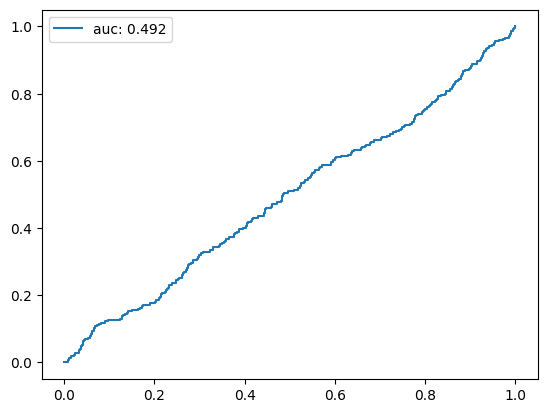

In [186]:
model = load_model(PATH_TO_MODELS/'origin'/'state_dict.pth', NUM_CLASSES)
model.to(DEVICE)

df_metrics, fnr, tnr = evaluate_unlearning(model)
display(df_metrics)

plt.plot(fnr, tnr, label=f'auc: {metrics.auc(fnr, tnr):.3f}')
plt.legend()

#### <b>Evaluate retrained model</b>

 [=======================================>]  Step: 4ms | Tot: 730ms | Acc: 86.26%%% Top2 Acc: 96.39% 77/77  
 [================================>.......]  Step: 4ms | Tot: 24ms | Acc: 50.74%%% Top2 Acc: 75.56% 5/5  
 [======================================>.]  Step: 4ms | Tot: 157ms | Acc: 61.34%%% Top2 Acc: 82.48% 21/21  
 [======================================>.]  Step: 6ms | Tot: 157ms | Acc: 57.61%%% Top2 Acc: 80.46% 20/20  
Shadow logits were brought from cache


100%|██████████| 81/81 [00:00<00:00, 85.99it/s] 


,retain_acc,forget_acc,test_acc,unseen_acc,MIA_AUC,MIA_TNR@1%FNR
0,86.26,50.74,61.34,57.61,79.77,23.7


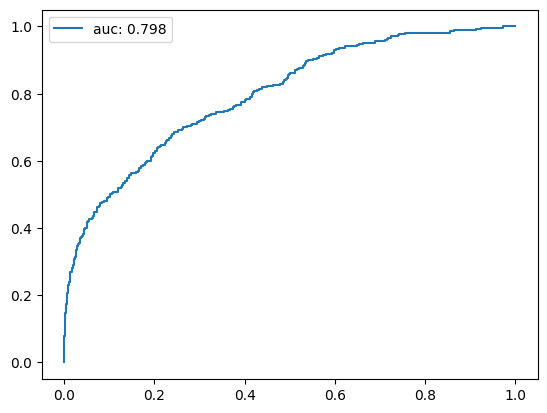

In [187]:
model = load_model(PATH_TO_MODELS/'retrained'/'state_dict.pth', NUM_CLASSES)
model.to(DEVICE)

df_metrics, fnr, tnr = evaluate_unlearning(model)
display(df_metrics)

plt.plot(fnr, tnr, label=f'auc: {metrics.auc(fnr, tnr):.3f}')
plt.legend()

#### <b>Unlearning</b>

In [188]:
forget_manifest = pd.read_csv(PATH_TO_DATA/'forget_manifest.csv')
retain_manifest = pd.read_csv(PATH_TO_DATA/'retain_manifest.csv')
unseen_manifest = pd.read_csv(PATH_TO_DATA/'unseen_manifest.csv')

##### <b>Fine Tuning</b>

In [189]:
def fine_tune_unlearning(model, forget_manifest, retain_manifest, unseen_manifest):
    
    model.train()
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    dataset = CustomDataset(retain_manifest, PATH_TO_DATA/'images', train_mode=True)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

    num_epochs = 10
    for epoch in range(num_epochs):
        for inputs, targets in tqdm(dataloader, desc=f'epoch {epoch}/{num_epochs}', leave=False):
            
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()

 [=======================================>]  Step: 5ms | Tot: 711ms | Acc: 88.66%%% Top2 Acc: 97.13% 77/77   
 [================================>.......]  Step: 4ms | Tot: 25ms | Acc: 69.63%%% Top2 Acc: 88.52% 5/5  
 [======================================>.]  Step: 4ms | Tot: 170ms | Acc: 62.58%%% Top2 Acc: 82.33% 21/21  
 [======================================>.]  Step: 5ms | Tot: 156ms | Acc: 57.85%%% Top2 Acc: 78.02% 20/20  
Shadow logits were brought from cache


100%|██████████| 81/81 [00:00<00:00, 81.77it/s] 


,retain_acc,forget_acc,test_acc,unseen_acc,MIA_AUC,MIA_TNR@1%FNR,unlearning_time
0,88.66,69.63,62.58,57.85,60.25,7.78,17


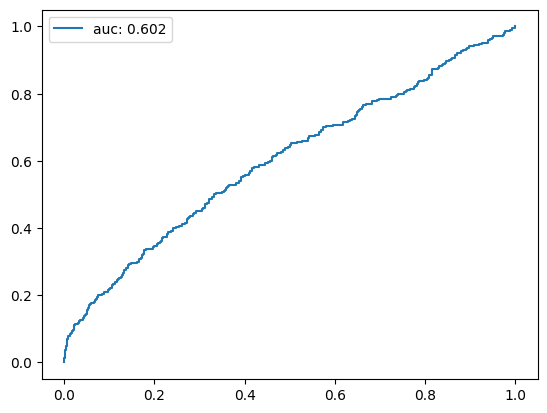

In [190]:
model = load_model(PATH_TO_MODELS/'origin'/'state_dict.pth', NUM_CLASSES)
model.to(DEVICE)

start = time.time()
fine_tune_unlearning(model, forget_manifest, retain_manifest, unseen_manifest)
unlearning_time = time.time() - start

df_metrics, fnr, tnr = evaluate_unlearning(model)
df_metrics['unlearning_time'] = round(unlearning_time)
display(df_metrics)

plt.plot(fnr, tnr, label=f'auc: {metrics.auc(fnr, tnr):.3f}')
plt.legend()

##### <b>Fine Tuning with random labels</b>

In [215]:
def random_labels_unlearning(model, forget_manifest, retain_manifest, unseen_manifest):

    set_random_seed(RANDOM_STATE)

    class CustomDataset(Dataset):
        def __init__(self, manifest, targets):
            self.dataset = KoreanDataset(manifest, PATH_TO_DATA/'images', train_mode=True)
            self.targets = targets

        def __len__(self):
            return len(self.dataset)

        def __getitem__(self, index):
            return self.dataset[index][0], self.targets[index]

    retain_targets = KoreanDataset(retain_manifest, PATH_TO_DATA/'images', train_mode=False).labels

    inds = pd.concat([retain_manifest, forget_manifest], ignore_index=True)
    targets = np.concatenate([retain_targets, np.random.randint(0, NUM_CLASSES, size=len(forget_manifest))])

    dataset = CustomDataset(inds, targets)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

    model.train()
    model.to(DEVICE)
    
    CE = torch.nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=5e-5)

    num_epochs = 10
    for epoch in range(num_epochs):
        for inputs, labels in tqdm(dataloader, desc=f'epoch {epoch}/{num_epochs}', leave=False):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            outputs = model(inputs)
            loss = CE(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()

 [=======================================>]  Step: 4ms | Tot: 700ms | Acc: 92.66%%% Top2 Acc: 98.61% 77/77  7 =====================>..................]  Step: 5ms | Tot: 391ms | Acc: 92.86%%% Top2 Acc: 98.51% 42/77 
 [================================>.......]  Step: 5ms | Tot: 27ms | Acc: 44.07%%% Top2 Acc: 70.00% 5/5  
 [======================================>.]  Step: 4ms | Tot: 164ms | Acc: 62.11%%% Top2 Acc: 81.33% 21/21  
 [======================================>.]  Step: 5ms | Tot: 156ms | Acc: 57.54%%% Top2 Acc: 79.04% 20/20  
Shadow logits were brought from cache


100%|██████████| 81/81 [00:00<00:00, 84.82it/s] 


,retain_acc,forget_acc,test_acc,unseen_acc,MIA_AUC,MIA_TNR@1%FNR,unlearning_time
0,92.66,44.07,62.11,57.54,77.24,24.81,18


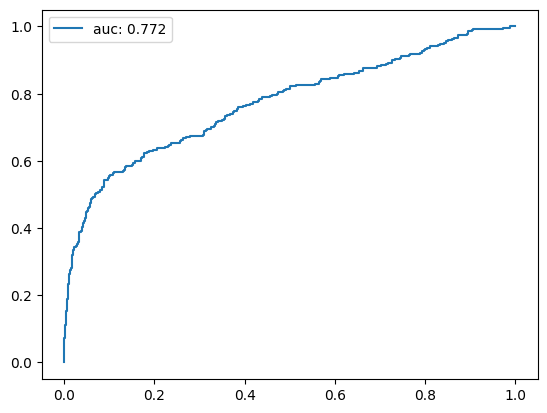

In [216]:
model = load_model(PATH_TO_MODELS/'origin'/'state_dict.pth', NUM_CLASSES)
model.to(DEVICE)

start = time.time()
random_labels_unlearning(model, forget_manifest, retain_manifest, unseen_manifest)
unlearning_time = time.time() - start

df_metrics, fnr, tnr = evaluate_unlearning(model)
df_metrics['unlearning_time'] = round(unlearning_time)
display(df_metrics)

plt.plot(fnr, tnr, label=f'auc: {metrics.auc(fnr, tnr):.3f}')
plt.legend()

##### <b>Fine Tuning with NOT random labels</b>

In [205]:
def not_random_labels_unlearning(model, forget_manifest, retain_manifest, unseen_manifest):

    set_random_seed(RANDOM_STATE)

    feature_extractor = models.convnext_tiny(weights='DEFAULT')
    def get_features(name):
        def hook(model, input, output):
            features[name] = output.detach()
        return hook
    feature_extractor.avgpool.register_forward_hook(get_features('feats'))
    feature_extractor.eval()
    feature_extractor.to(DEVICE)

    model.eval()
    model.to(DEVICE)

    unseen_dataset = KoreanDataset(unseen_manifest, PATH_TO_DATA/'images', train_mode=False)
    unseen_dataloader = DataLoader(unseen_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
    forget_dataset = KoreanDataset(forget_manifest, PATH_TO_DATA/'images', train_mode=False)
    forget_dataloader = DataLoader(forget_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

    forget_feats = []
    forget_preds = []
    forget_targets = []

    unseen_feats = []
    unseen_preds = []
    unseen_targets = []

    features = {}

    for inputs, targets in tqdm(unseen_dataloader):
        inputs = inputs.to(DEVICE)
        unseen_preds.append(model(inputs).log_softmax(1).detach().cpu())
        feature_extractor(inputs)
        unseen_feats.append(features['feats'].squeeze().cpu())
        unseen_targets.append(targets.detach().cpu())

    unseen_preds = torch.cat(unseen_preds)
    unseen_feats = torch.cat(unseen_feats)
    unseen_targets = torch.cat(unseen_targets)

    for inputs, targets in tqdm(forget_dataloader):
        inputs = inputs.to(DEVICE)
        forget_preds.append(model(inputs).log_softmax(1).detach().cpu())
        feature_extractor(inputs)
        forget_feats.append(features['feats'].squeeze().cpu())
        forget_targets.append(targets.detach().cpu())

    forget_preds = torch.cat(forget_preds)
    forget_feats = torch.cat(forget_feats)
    forget_targets = torch.cat(forget_targets)

    # change targets with closest from unseen
    for i, x in enumerate(forget_feats):
        j = torch.topk(F.cosine_similarity(x, unseen_feats), 1).indices
        forget_preds[i] = unseen_preds[j].mean(axis=0)
        forget_targets[i] = torch.mode(unseen_targets[j]).values


    retain_targets = torch.tensor(KoreanDataset(retain_manifest, PATH_TO_DATA/'images', train_mode=False).labels)

    inds = pd.concat([retain_manifest, forget_manifest], ignore_index=True)
    targets = torch.cat([retain_targets, forget_targets])

    class CustomDataset(Dataset):
        def __init__(self, manifest, targets):
            self.dataset = KoreanDataset(manifest, PATH_TO_DATA/'images', train_mode=True)
            self.targets = targets

        def __len__(self):
            return len(self.dataset)

        def __getitem__(self, index):
            return self.dataset[index][0], self.targets[index]

    dataset = CustomDataset(inds, targets)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

    model.train()
    model.to(DEVICE)
    
    CE = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    num_epochs = 10
    for epoch in range(num_epochs):
        for inputs, labels in tqdm(dataloader, desc=f'epoch {epoch}/{num_epochs}', leave=False):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            outputs = model(inputs)
            loss = CE(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()

100%|██████████| 5/5 [00:00<00:00,  7.08it/s]


 [=======================================>]  Step: 4ms | Tot: 732ms | Acc: 89.42%%% Top2 Acc: 98.07% 77/77   
 [================================>.......]  Step: 4ms | Tot: 25ms | Acc: 47.78%%% Top2 Acc: 70.74% 5/5  
 [======================================>.]  Step: 4ms | Tot: 163ms | Acc: 61.03%%% Top2 Acc: 81.02% 21/21  
 [======================================>.]  Step: 5ms | Tot: 154ms | Acc: 56.91%%% Top2 Acc: 77.63% 20/20  
Shadow logits were brought from cache


100%|██████████| 81/81 [00:00<00:00, 83.38it/s]


,retain_acc,forget_acc,test_acc,unseen_acc,MIA_AUC,MIA_TNR@1%FNR,unlearning_time
0,89.42,47.78,61.03,56.91,76.17,21.11,20


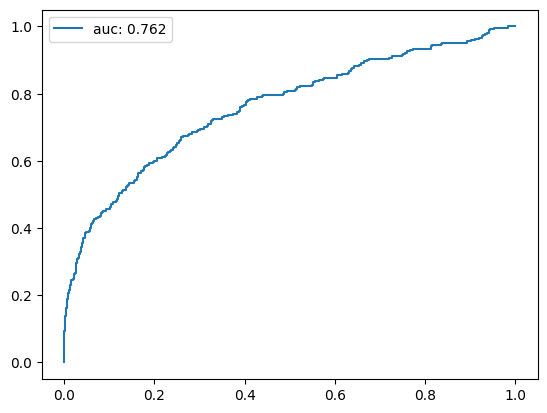

In [206]:
model = load_model(PATH_TO_MODELS/'origin'/'state_dict.pth', NUM_CLASSES)
model.to(DEVICE)

start = time.time()
not_random_labels_unlearning(model, forget_manifest, retain_manifest, unseen_manifest)
unlearning_time = time.time() - start

df_metrics, fnr, tnr = evaluate_unlearning(model)
df_metrics['unlearning_time'] = round(unlearning_time)
display(df_metrics)

plt.plot(fnr, tnr, label=f'auc: {metrics.auc(fnr, tnr):.3f}')
plt.legend()

##### <b>UnGAN</b>

In [45]:
hidden_size=64

class Discriminator(nn.Module):
    def __init__(self, num_classes):
        super(Discriminator, self).__init__()
        self.class_embeddings = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(2*num_classes, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2*hidden_size),
            nn.ReLU(),
            nn.Linear(2*hidden_size, 2*hidden_size),
            nn.ReLU(),
            nn.Linear(2*hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )
        
    def forward(self, logits, label):
        label_emb = self.class_embeddings(label)
        z = torch.hstack([logits, label_emb])
        return self.model(z).flatten()

class Trainer:
    def __init__(self, model):
        
        self.discriminator = Discriminator(8)
        self.model = model
        self.alpha = 50

        self.model.cuda()
        self.discriminator.cuda()
        
        self.d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=1e-3, weight_decay=1e-4)
        self.d_criterion = nn.BCEWithLogitsLoss()

        self.g_optimizer = torch.optim.Adam(self.model.parameters(), lr=2e-5, weight_decay=1e-5)
        self.g_criterion = nn.CrossEntropyLoss(reduction='mean')
        

    def generator_step(self, forget_logits, forget_labels, retain_logits, retain_labels):
        
        ones = torch.ones(forget_logits.size(0)).cuda()
        forget_preds = self.discriminator(forget_logits, forget_labels)
        d_loss = self.d_criterion(forget_preds, ones)
        
        g_loss = self.g_criterion(retain_logits, retain_labels)

        loss = d_loss + self.alpha * g_loss

        self.g_optimizer.zero_grad()
        loss.backward()
        self.g_optimizer.step()

        return loss.item()
        
    def discriminator_step(self, forget_logits, forget_labels, unseen_logits, unseen_labels):
        
        ones = torch.ones(unseen_logits.size(0)).cuda()
        zeros = torch.zeros(forget_logits.size(0)).cuda()
    
        forget_preds = self.discriminator(forget_logits, forget_labels)
        unseen_preds = self.discriminator(unseen_logits, unseen_labels)
    
        loss = self.d_criterion(forget_preds, zeros) + self.d_criterion(unseen_preds, ones)
        self.d_optimizer.zero_grad()
        loss.backward()
        self.d_optimizer.step()

        return loss.item()
        
        
def ungan_unlearning(model, forget_manifest, retain_manifest, unseen_manifest):

    trash_path = Path('trash.txt')
    loss_path = Path('gan_loss.txt')
    metrics_path = Path('gan_metrics.txt')
    loss_path.write_text('step,D_loss,G_loss\n')
    metrics_path.write_text('step,forget_JS,valid_JS,forget_accuracy,valid_accuracy,retain_accuracy\n')
    trash_path.write_text('n,d_loss')
    
    
    dataset = CustomDataset(forget_manifest, PATH_TO_DATA/'images', train_mode=False)
    forget = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

    dataset = CustomDataset(retain_manifest, PATH_TO_DATA/'images', train_mode=True)
    retain = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

    dataset = CustomDataset(unseen_manifest, PATH_TO_DATA/'images', train_mode=False)
    unseen = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)


    trainer = Trainer(model)
    epochs = 10
    step = 0
    n_range = 5
    num_discriminator_steps = 1
    num_generator_steps = 3
    discriminator_pretraining_steps = 200

    trainer.model.eval()
            
    unseen_logits_all, unseen_labels_all = [], []
    with torch.no_grad():
        for u in tqdm(unseen, desc='score unseen', leave=False):
            unseen_logits_all.append(trainer.model(u[0].to(DEVICE)))
            unseen_labels_all.append(u[1].to(DEVICE))
    unseen_logits_all = torch.cat(unseen_logits_all)
    unseen_labels_all = torch.cat(unseen_labels_all)
        
    forget_logits_all, forget_labels_all = [], []
    with torch.no_grad():
        for f in tqdm(unseen, desc='score unseen', leave=False):
            forget_logits_all.append(trainer.model(f[0].to(DEVICE)))
            forget_labels_all.append(f[1].to(DEVICE))
    forget_logits_all = torch.cat(forget_logits_all)
    forget_labels_all = torch.cat(forget_labels_all)

    # valid_scores = score_model(trainer.model, unseen, progress=False)
    # forget_scores = score_model(trainer.model, forget, progress=False)
    # retain_scores = score_model(trainer.model, retain, progress=False)
    # print(accuracy_score(valid_scores.labels, valid_scores.preds), JS_divergence_single(
    #             valid_scores.loss.apply(lambda x: np.log(x+1e-4)).tolist(), 
    #             forget_scores.loss.apply(lambda x: np.log(x+1e-4)).tolist(), 
    #             plot=False), accuracy_score(retain_scores.labels, retain_scores.preds), accuracy_score(forget_scores.labels, forget_scores.preds))

                
    # discriminator pretraining
    for n in range(discriminator_pretraining_steps):

        inds = np.random.choice(len(unseen_logits_all), size=BATCH_SIZE, replace=False)
        forget_logits, forget_labels = unseen_logits_all[inds], unseen_labels_all[inds]
                    
        inds = np.random.choice(len(unseen_logits_all), size=BATCH_SIZE, replace=False)
        unseen_logits, unseen_labels = unseen_logits_all[inds], unseen_labels_all[inds]
            
        d_loss = trainer.discriminator_step(forget_logits, forget_labels, unseen_logits, unseen_labels)

                        
    for epoch in tqdm(range(epochs)):
        
        # discriminator step
        trainer.model.eval()
        # n = 0
        # average_loss = 100
        for n in range(num_discriminator_steps):
            for forget_batch in forget:
            
                with torch.no_grad():
                    forget_logits, forget_labels = trainer.model(forget_batch[0].to(DEVICE)), forget_batch[1].to(DEVICE)

                inds = np.random.choice(len(unseen_logits_all), size=BATCH_SIZE, replace=False)
                unseen_logits, unseen_labels = unseen_logits_all[inds], unseen_labels_all[inds]

                d_loss = trainer.discriminator_step(forget_logits, forget_labels, unseen_logits, unseen_labels)
                # average_loss = d_loss if average_loss == 100 else 0.5 * average_loss + 0.5 * d_loss

                # with open(trash_path, 'a') as file:
                #     print(n, d_loss, average_loss, file=file)
            
                # n += 1
            
        #     if n >= n_range:
        #         break

        # n_range = min(n_range//2, 1) if average_loss < 1.0 else 25

        # generator step
        for n in range(num_generator_steps):
            for (forget_batch, retain_batch) in zip(forget, retain):
                
                step+= 1
            
                trainer.model.train()
                retain_features, retain_labels = retain_batch[0].cuda(), retain_batch[1].cuda()
                retain_logits = trainer.model(retain_features)
                
                trainer.model.eval()
                forget_features, forget_labels = forget_batch[0].cuda(), forget_batch[1].cuda()
                forget_logits = trainer.model(forget_features)

                g_loss = trainer.generator_step(forget_logits, forget_labels, retain_logits, retain_labels)
                
                # with torch.no_grad():
                #     # inds = np.random.choice(len(unseen_logits_all), size=BATCH_SIZE, replace=False)
                #     # unseen_logits, unseen_labels = unseen_logits_all[inds], unseen_labels_all[inds]

                #     # ones = torch.ones(unseen_logits.size(0)).cuda()
                #     # zeros = torch.zeros(forget_logits.size(0)).cuda()
                
                #     # forget_preds = trainer.discriminator(forget_logits, forget_labels)
                #     # unseen_preds = trainer.discriminator(unseen_logits, unseen_labels)
                
                #     # d_loss = trainer.d_criterion(forget_preds, zeros) + trainer.d_criterion(unseen_preds, ones)

                #     print(average_loss)
        
                #     average_loss = g_loss if average_loss == 100 else 0.5 * average_loss + 0.5 * g_loss


        # with open(loss_path, 'a') as file:
        #     print(step, d_loss, g_loss, file=file, sep=',')
        # fs = score_model(trainer.model, forget, progress=False)
        # vs = score_model(trainer.model, unseen, progress=False)
        # rs = score_model(trainer.model, retain, progress=False)

        # f_js = JS_divergence_single(
        #     fs.loss.apply(lambda x: np.log(x+1e-4)).tolist(), 
        #     valid_scores.loss.apply(lambda x: np.log(x+1e-4)).tolist(), 
        #     plot=False)
        # v_js = JS_divergence_single(
        #     vs.loss.apply(lambda x: np.log(x+1e-4)).tolist(), 
        #     valid_scores.loss.apply(lambda x: np.log(x+1e-4)).tolist(), 
        #     plot=False)
        # af = accuracy_score(fs.labels, fs.preds)
        # av = accuracy_score(vs.labels, vs.preds)
        # ar = accuracy_score(rs.labels, rs.preds)

    
        # with open(metrics_path, 'a') as file:
        #     print(step, f_js, v_js, af, av, ar, file=file, sep=',')



    trainer.model.eval()

In [46]:
from scipy.stats import gaussian_kde
from sklearn.metrics import accuracy_score

def JS_divergence_single(ksi, psi, plot=False):
    p, q = gaussian_kde(ksi), gaussian_kde(psi)
    x = np.linspace(min(min(ksi), min(psi)), max(max(ksi), max(psi)))
    js = 0.5*np.sum(q(x) * np.log(q(x) / p(x))) + 0.5*np.sum(p(x) * np.log(p(x) / q(x)))
    if plot:
        fig, axs = plt.subplots(1, 1, figsize=(4, 3))
        axs.hist(ksi, bins=101, density=True, color='C0', alpha=0.75)
        axs.hist(psi, bins=101, density=True, color='C1', alpha=0.75)
        axs.plot(x, p(x), color='C4', lw=3)
        axs.plot(x, q(x), color='C3', lw=3)
        axs.set_title(f'KL={js:.3f}')
    return js

def score_model(model, dataloader, progress=True):
    model.eval()
    model.to(DEVICE)
    loss_fn = nn.CrossEntropyLoss(reduction='none')
    
    all_labels = []
    all_output = []
    all_loss = []

    with torch.no_grad():
        for features, labels in tqdm(dataloader, leave=False, disable=not progress):
            features, labels = features.to(DEVICE), labels.to(DEVICE)
            output = model(features)
            loss = loss_fn(output, labels)

            all_labels.append(labels)
            all_output.append(output)
            all_loss.append(loss)

        all_labels = torch.cat(all_labels)
        all_output = torch.cat(all_output)
        all_loss = torch.cat(all_loss)
        

        result_dict = dict()
        result_dict['labels'] = all_labels.detach().cpu().flatten().numpy()
        result_dict['preds'] = all_output.argmax(1).detach().cpu().flatten().numpy()
        result_dict['logits'] = all_output.detach().cpu().numpy().tolist()
        result_dict['loss'] = all_loss.detach().cpu().numpy().tolist()
        

    df = pd.DataFrame(result_dict)
    
    return df


def JS_divergence(logits1, logits2, plot=False):
    n_classes = logits1.shape[1]
    js = np.zeros(n_classes)
    I, J = n_classes // 3 + n_classes % 3, 3
    if plot:
        fig, axs = plt.subplots(I, J, figsize=(20, 16))
    for i in range(n_classes):
        ksi, psi = logits1[:, i], logits2[:, i]
        p, q = gaussian_kde(ksi), gaussian_kde(psi)
        x = np.linspace(min(min(ksi), min(psi)), max(max(ksi), max(psi)))
        js[i] = 0.5*np.sum(q(x) * np.log(q(x) / p(x))) + 0.5*np.sum(p(x) * np.log(p(x) / q(x)))
        if plot:
            m, n = i // J, i % J
            axs[m, n].hist(ksi, bins=101, density=True, color='C0', alpha=0.75)
            axs[m, n].hist(psi, bins=101, density=True, color='C1', alpha=0.75)
            axs[m, n].plot(x, p(x), color='C4', lw=3)
            axs[m, n].plot(x, q(x), color='C3', lw=3)
            axs[m, n].set_title(f'class {i} KL={js[i]:.3f}')
    return js.mean() 

100%|██████████| 10/10 [00:44<00:00,  4.41s/it]              


 [=======================================>]  Step: 8ms | Tot: 770ms | Acc: 87.12%%% Top2 Acc: 96.48% 81/81  
 [======================================>.]  Step: 4ms | Tot: 163ms | Acc: 61.65%%% Top2 Acc: 83.10% 21/21  
Shadow logits were brought from cache


100%|██████████| 81/81 [00:00<00:00, 83.90it/s]


train acc: 87.12 top2 train acc: 96.48
test acc: 61.65 top2 test acc: 83.10
mia: 0.014814814814814836
unlearning time: 46.207274436950684


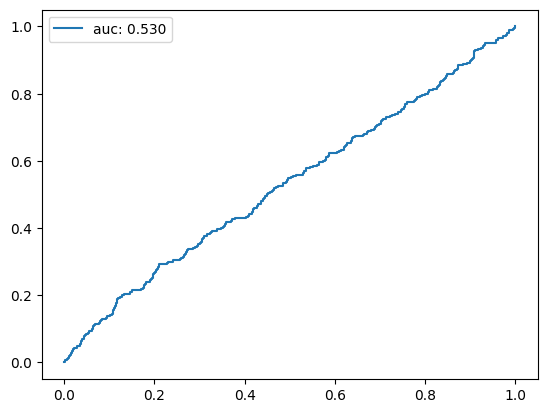

In [47]:
model = load_model(PATH_TO_MODELS/'origin'/'state_dict.pth', num_classes=8)
model.to(DEVICE)

start = time.time()
ungan_unlearning(model, forget_manifest, retain_manifest, unseen_manifest)
unlearning_time = time.time() - start

train_acc, test_acc, mia = evaluate_unlearning(model)

print(f'train acc: {train_acc[0]:.2f}', f'top2 train acc: {train_acc[1]:.2f}')
print(f'test acc: {test_acc[0]:.2f}', f'top2 test acc: {test_acc[1]:.2f}')
print(f'mia: {mia[-1]}')
print(f'unlearning time: {unlearning_time}')


plt.plot(mia[0], mia[1], label=f'auc: {metrics.auc(mia[0], mia[1]):.3f}')
plt.legend()

In [ ]:
dataset = CustomDataset(forget_manifest, PATH_TO_DATA/'images', train_mode=False)
forget = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

dataset = CustomDataset(retain_manifest, PATH_TO_DATA/'images', train_mode=False)
retain = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

dataset = CustomDataset(unseen_manifest, PATH_TO_DATA/'images', train_mode=False)
unseen = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

In [ ]:
retain_scores = score_model(model, retain)
forget_scores = score_model(model, forget)
unseen_scores = score_model(model, unseen)



In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

In [ ]:
df = pd.DataFrame(np.array(forget_scores.logits.tolist() + unseen_scores.logits.tolist()), columns=[str(x) for x in range(8)])
df['labels'] = forget_scores.labels.tolist() + unseen_scores.labels.tolist()
df['target'] = [0] * len(forget_scores) + [1] * len(unseen_scores)
df

,0,1,2,3,4,5,6,7,labels,target
0,3.169093,4.512546,5.989792,1.733747,-0.670496,-2.605949,-4.505379,-5.953965,1,0
1,-2.212783,2.090134,6.403109,2.467176,0.968879,-1.084058,-2.653425,-4.400949,2,0
2,-3.271266,0.500076,4.415346,1.855158,2.648744,0.645681,-1.306783,-3.189191,2,0
3,-3.526428,0.931274,8.516487,4.019893,1.407074,-0.895915,-2.807906,-5.320430,2,0
4,-1.423856,2.634564,7.368021,1.931728,0.263295,-1.454536,-2.988668,-4.250524,2,0
...,...,...,...,...,...,...,...,...,...,...
1539,1.755514,5.848326,1.274846,-0.520236,-0.708003,-1.059022,-2.433524,-2.376940,1,1
1540,6.074869,4.861422,4.616183,-0.048663,-1.550626,-3.627363,-4.273689,-4.899118,1,1
1541,2.377262,2.478751,0.754602,1.454976,0.566005,-0.517441,-1.288399,-4.177075,1,1
1542,0.892026,4.606267,3.622319,2.093643,1.067325,-2.357113,-3.368414,-5.013836,1,1


In [ ]:
m = GradientBoostingClassifier(max_depth=3, n_estimators=20)

m.fit(df[df.columns[:-1]], df['target'])

GradientBoostingClassifier(n_estimators=20)

In [ ]:
metrics.roc_auc_score(df['target'], m.predict_proba(df[df.columns[:-1]])[:, 1])

0.7741016919588348

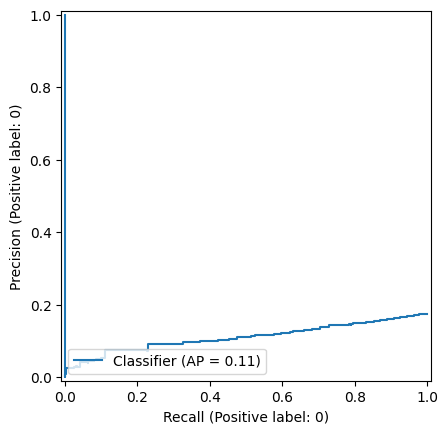

In [ ]:
metrics.PrecisionRecallDisplay.from_predictions(df['target'], m.predict_proba(df[df.columns[:-1]])[:, 1], pos_label=0)

1.406503288344711

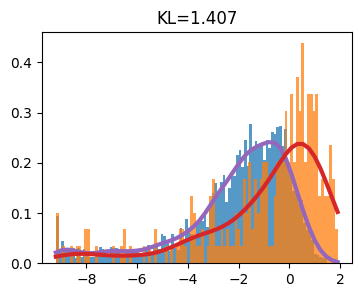

In [ ]:
JS_divergence_single(retain_scores.loss.apply(lambda x: np.log(x+1e-4)).tolist(), forget_scores.loss.apply(lambda x: np.log(x+1e-4)).tolist(), plot=True)

0.04824958284456753

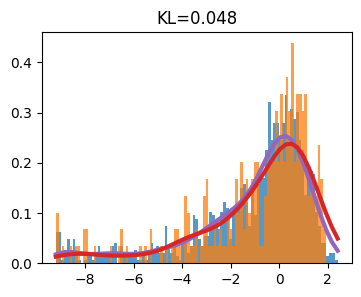

In [ ]:
JS_divergence_single(unseen_scores.loss.apply(lambda x: np.log(x+1e-4)).tolist(), forget_scores.loss.apply(lambda x: np.log(x+1e-4)).tolist(), plot=True)

1.219754960929904

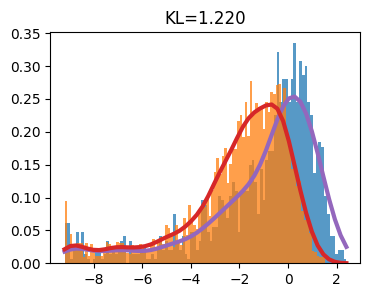

In [ ]:
JS_divergence_single(unseen_scores.loss.apply(lambda x: np.log(x+1e-4)).tolist(), retain_scores.loss.apply(lambda x: np.log(x+1e-4)).tolist(), plot=True)

0.033770084932791294

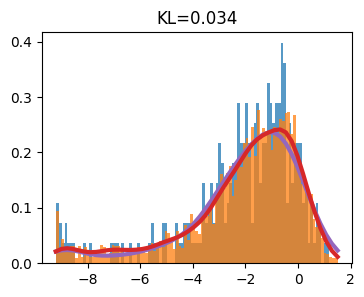

In [ ]:
JS_divergence_single(retain_scores.loss.sample(270).apply(lambda x: np.log(x+1e-4)).tolist(), retain_scores.loss.apply(lambda x: np.log(x+1e-4)).tolist(), plot=True)

0.029201120613321127

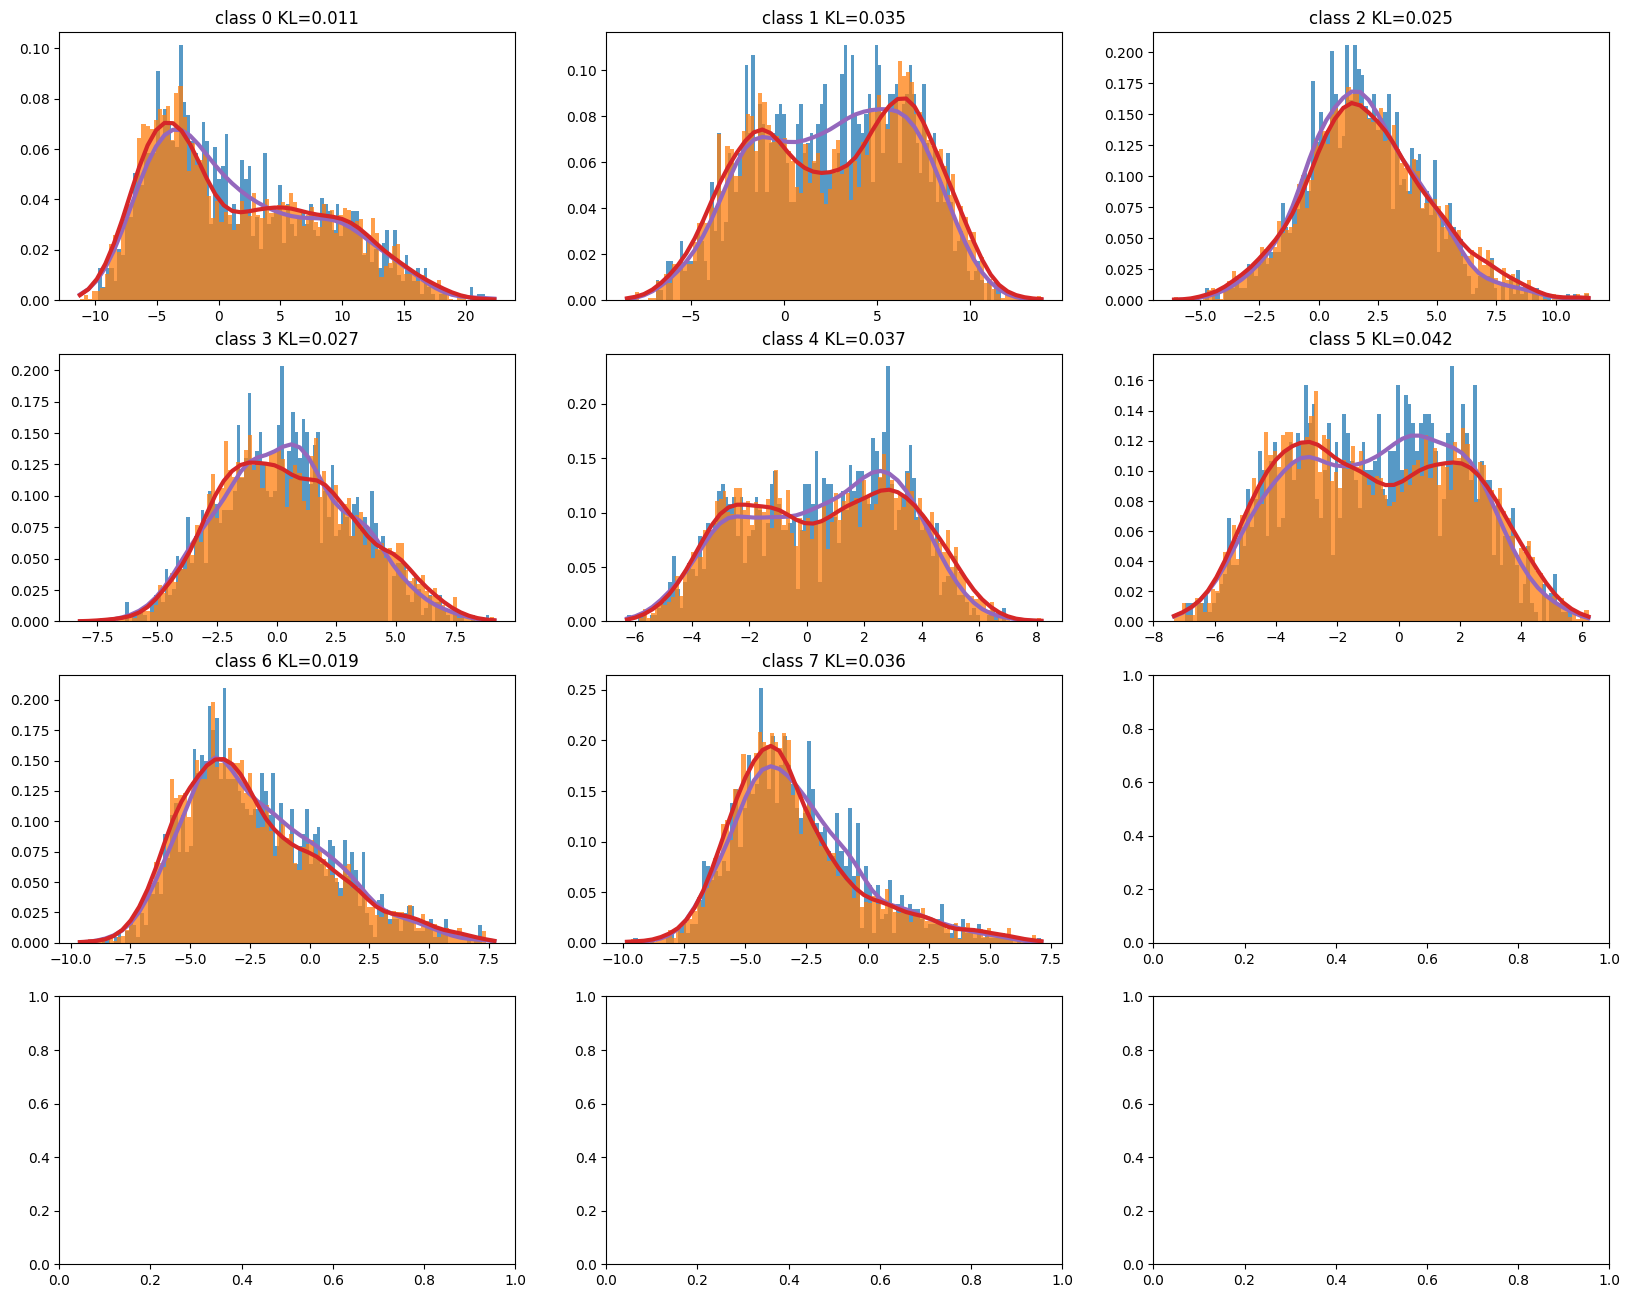

In [ ]:
JS_divergence(np.array(unseen_scores.logits.tolist()), np.array(retain_scores.logits.tolist()), plot=True)

0.04254951087118343

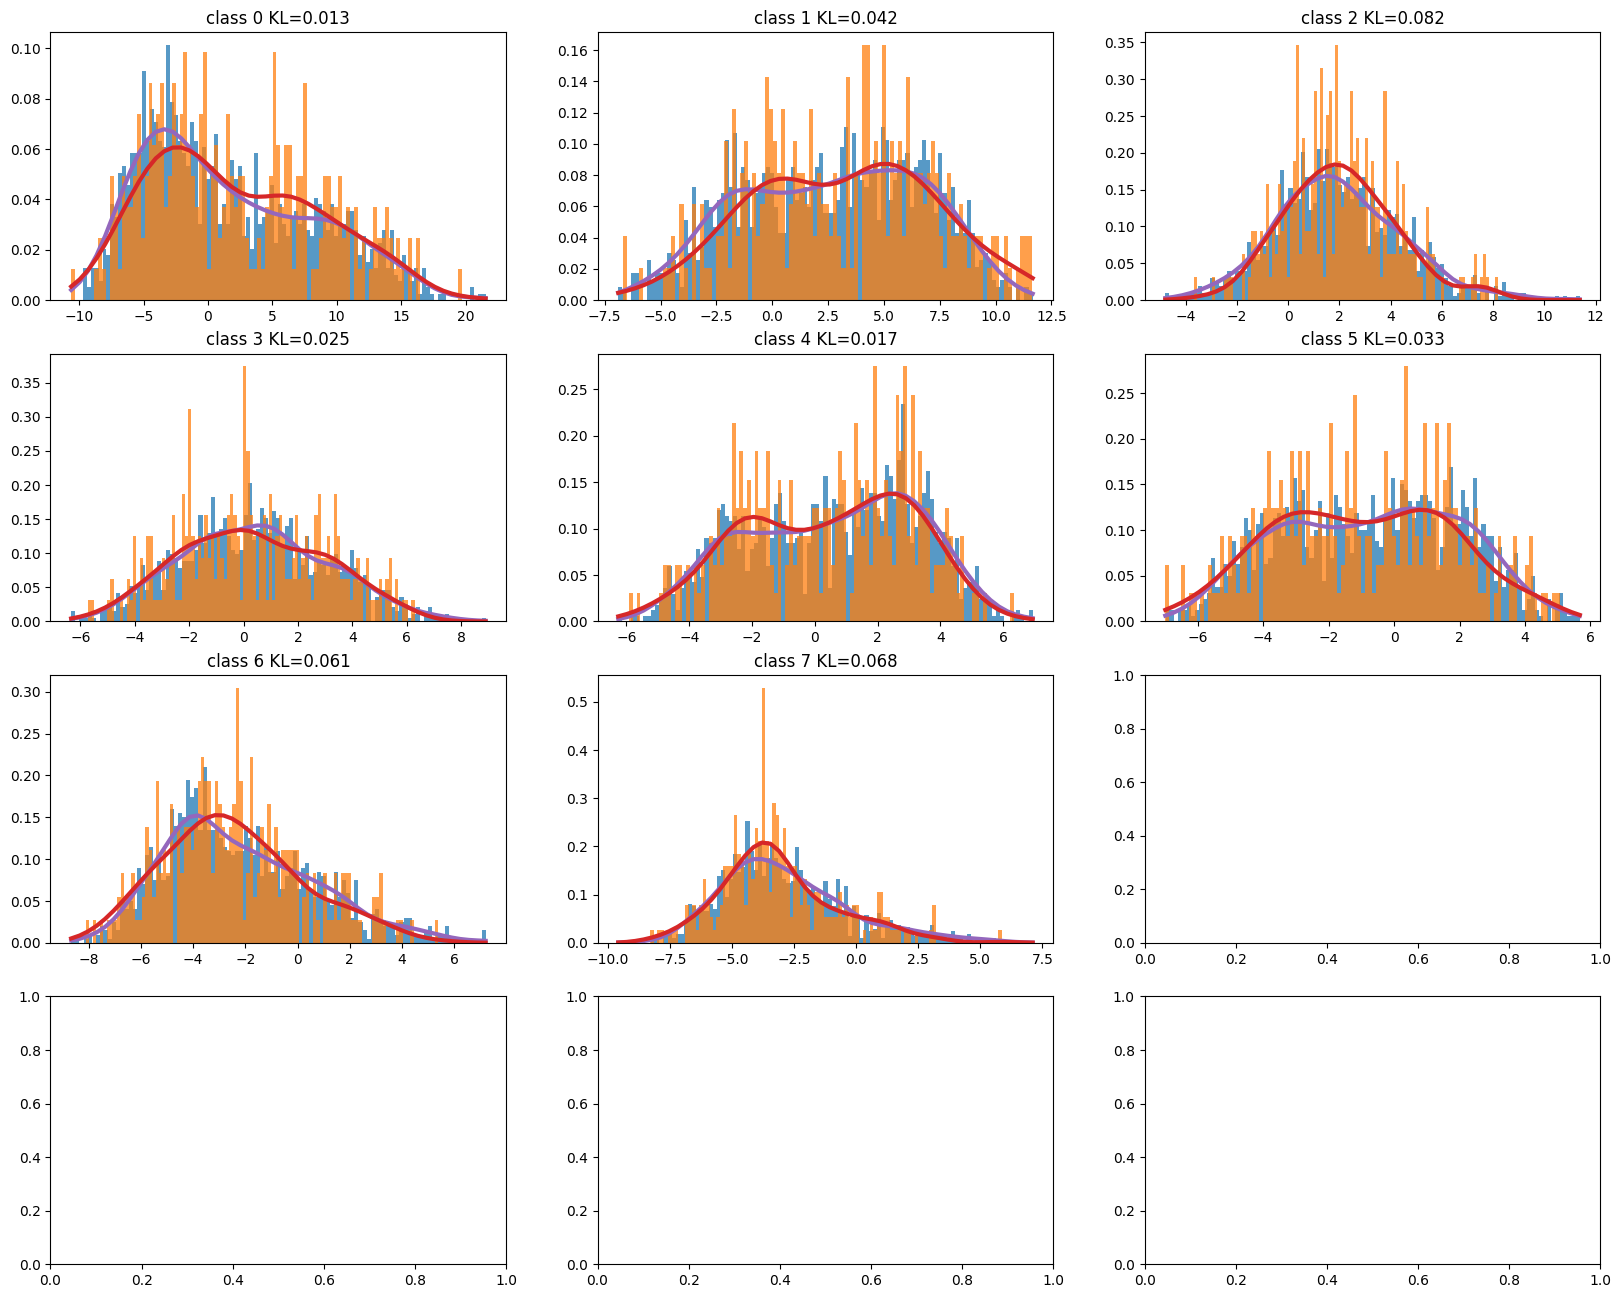

In [ ]:
JS_divergence(np.array(unseen_scores.logits.tolist()), np.array(forget_scores.logits.tolist()), plot=True)

In [ ]:
trainer = Trainer(model)

In [ ]:
for p in trainer.discriminator.parameters():
    break

In [ ]:
None > 1.2

TypeError: '>' not supported between instances of 'NoneType' and 'float'

In [ ]:
model.eval()
unseen_logits, unseen_labels = [], []

for u in tqdm(unseen, desc='score unseen', leave=False):
    unseen_logits.append(model(u[0].to(DEVICE)))
    unseen_labels.append(u[1].to(DEVICE))

unseen_logits = torch.cat(unseen_logits)
unseen_labels = torch.cat(unseen_labels)

In [ ]:
unseen_logits.requires_grad

True

In [75]:
train_inds = np.array([10, 19, 53, 15, 1])
foget_inds = np.array([53, 19])

In [72]:
a = np.put(np.ones(10), [0, 9, 5], 0)
a

In [73]:
np.wherenp.arange(10)

array([1, 0, 0, 1, 1])

In [79]:
np.isin(foget_inds, train_inds)


array([ True,  True])